* This notebook contains simulation of the quantum dynamics in the radical-pair mechanism in the case when the hyperfine interaction is described via nuclear spin operator.

* Here, the dynamics is governed by a two-spin Hamiltonian
$$
        \hat{H}=2\mu_B\left(\hat{\mathbf{S}}_1+\hat{\mathbf{S}}_2\right)\cdot\mathbf{B}+\hat{\mathbf{S}}_1\cdot\hat{A}\cdot\hat{\mathbf{I}},
$$
where
$$
    \hat{\mathbf{S}}_1\cdot\hat{A}\cdot\hat{\mathbf{I}}=A_x\hat{S}_{1x}\hat{I}_x+A_y\hat{S}_{1y}\hat{I}_y+A_z\hat{S}_{1z}\hat{I}_z,
$$
and $A_x, A_y, A_z$ are the eigenvalues of $\hat{A}$.

* Whenever we introduce an RF field, it is perpendicular to the DC field.
***

# Setup
The quantum simulation is done in QuTiP and we're also using numpy

In [1]:
from matplotlib import pyplot as plt
from qutip import *
import numpy as np
from pylab import pad

### Physical constants and parameters
We set $\hbar = 1$. When factor = 1, the energy is in units of eV and the Magnetic field is in units of Tesla.
Setting factor = 1e-6, converts the units in such way that the time has units of $\mu$s. Instead of defining the nuclear magnetic field explicitely, we use the corresponding hyperfine tensor component in the Hamiltonian.

In [6]:
factor = 1e-6  # uncomment for micro units
hbar = 1
pi = np.pi

# Bohr magneton in eV/Tesla
muB = 5.788e-5

# factor = 1   # uncomment for SI units
gama = muB * 0.1519756e16 * factor  # in sec-1/Tesla (Converted using natural units, by taking hbar=1)

# Geomagnetic field in Tesla
Bgeo = 47e-6

# Disturbing RF field of strength 150 nanoTesla
Brf = 150e-9

# RF frequency (corresponding to the Geomagnetic field Larmor frequency)
w = 2 * gama * Bgeo

# Yield decay rate
k = 1e4 * factor

# Hyperfine tensor components
Az = 1e-8 * 0.1519756e16 * factor
Ax = Az/2
Ay = Az/2

### Define quantum states.
The radical pair itself is descrbed in a 4D basis of tensor products of up/down basis of individual spins.

In [7]:
up = basis(2, 0)
down = basis(2, 1)
S = (tensor(up, down) - tensor(down, up)).unit()  # Singlet state
T0 = (tensor(up, down) + tensor(down, up)).unit()  # Triplet state with zero spin projection
Tu = tensor(up, up)  # Triplet state with spin projection +1
Td = tensor(down, down)  # Triplet state with spin projection -1

### Add the nuclear spin state to the basis, together with two shelving (steady-state) states corresponding to the singlet and triplet yield.
All states are written as $|\ \rangle_{I} \otimes |\ \rangle_{1} \otimes |\ \rangle_{2}$
With these states the number of dimensions is $2\times4 + 2 = 10$, so we expand the singlet and triplet states with "pad".

In [8]:
uTu = Qobj(pad(tensor(up, Tu).unit(), ((0, 2), (0, 0))))  # Nuclear spin up & triplet with m=+1
uT0 = Qobj(pad(tensor(up, T0).unit(), ((0, 2), (0, 0))))  # Nuclear spin up & triplet with m=0
uTd = Qobj(pad(tensor(up, Td).unit(), ((0, 2), (0, 0))))  # Nuclear spin up & triplet with m=-1
uS = Qobj(pad(tensor(up, S).unit(), ((0, 2), (0, 0))))  # Nuclear spin up & singlet
dTu = Qobj(pad(tensor(down, Tu).unit(), ((0, 2), (0, 0))))  # Nuclear spin down & triplet with m=+1
dT0 = Qobj(pad(tensor(down, T0).unit(), ((0, 2), (0, 0))))  # Nuclear spin down & triplet with m=0
dTd = Qobj(pad(tensor(down, Td).unit(), ((0, 2), (0, 0))))  # Nuclear spin down & triplet with m=-1
dS = Qobj(pad(tensor(down, S).unit(), ((0, 2), (0, 0))))  # Nuclear spin down & singlet
SYield = basis(10, 8)  # shelving state for the singlet yield after recombination
TYield = basis(10, 9)  # shelving state for the triplet yield after recombination

SY = ket2dm(SYield)

# Defining Projection operators
P1 = SYield * uS.dag() * np.sqrt(k)
P2 = TYield * uT0.dag() * np.sqrt(k)
P3 = TYield * uTu.dag() * np.sqrt(k)
P4 = TYield * uTd.dag() * np.sqrt(k)
P5 = SYield * dS.dag() * np.sqrt(k)
P6 = TYield * dT0.dag() * np.sqrt(k)
P7 = TYield * dTu.dag() * np.sqrt(k)
P8 = TYield * dTd.dag() * np.sqrt(k)

c_op_list = [P1, P2, P3, P4, P5, P6, P7, P8]  # putting them together in a list

### Operators in terms of the basis states:

In [9]:
# Electron Zeeman operators. First operator in tensor products always corresponds to the nucleus
S1x = tensor(qeye(2), sigmax(), qeye(2))  # Sx operator for electron 1: 1 x Sx x 1#
S2x = tensor(qeye(2), qeye(2), sigmax())  # Sx operator for electron 2: 1 x 1 x Sx #
Sx = S1x + S2x  # Total Sx operator
Sx = Qobj(pad(Sx.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))  # make it 10 dimensional

S1y = tensor(qeye(2), sigmay(), qeye(2))  # Sy operator for electron 1: 1 x Sy x 1
S2y = tensor(qeye(2), qeye(2), sigmay())  # Sy operator for electron 2: 1 x 1 x Sy
Sy = S1y + S2y  # Total Sy operator
Sy = Qobj(pad(Sy.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))  # make it 10 dimensional

S1z = tensor(qeye(2), sigmaz(), qeye(2))  # Sz operator for electron 1: 1 x Sz x 1
S2z = tensor(qeye(2), qeye(2), sigmaz())  # Sz operator for electron 2: 1 x 1 x Sz
Sz = S1z + S2z  # Total Sz operator
Sz = Qobj(pad(Sz.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))  # make it 10 dimensional

# Hyperfine operators
ISx = tensor(sigmax(), qeye(2), sigmax())  # Ix x 1 x Sx
ISy = tensor(sigmay(), qeye(2), sigmay())  # Iy x 1 x Sy
ISz = tensor(sigmaz(), qeye(2), sigmaz())  # Iz x 1 x Sz
ISx = Qobj(pad(ISx.full(), ((0, 2), (0, 2)), 'constant', constant_values=0))  # make it 10-dimensional
ISy = Qobj(pad(ISy.full(), ((0, 2), (0, 2)), 'constant', constant_values=0))  # make it 10-dimensional
ISz = Qobj(pad(ISz.full(), ((0, 2), (0, 2)), 'constant', constant_values=0))  # make it 10-dimensional

### DC and RF Hamiltonians.


In [10]:
# Hyperfine Interaction
Hhf = (Ax * ISx + Ay * ISy + Az * ISz)

# DC Hamiltonian
def H0(theta: float) -> object:
    # Zeeman Hamiltonian
    Bx = Bgeo * np.sin(theta)
    By = 0
    Bz = Bgeo * np.cos(theta)
    Hz = gama * (Sx * Bx + Sy * By + Sz * Bz)
    return Hz + Hhf

# Arguments of the RF field
args = {'A': Brf, 'freq': w}

# RF field
def Bt(t, args):
    A = args['A']  # amplitude of the oscilating field
    freq = args['freq']  # frequency of the oscilating field
    return A * np.cos(t * freq)

# RF Hamiltonian
def H_RF(theta, args):
    th_rf = theta + np.pi / 2.
    Bxrf = np.sin(th_rf)
    Byrf = 0.0
    Bzrf = np.cos(th_rf)
    Hrf = gama * (Sx * Bxrf + Sy * Byrf + Sz * Bzrf)
    return [Hrf, Bt]  # Time-dependent Hamiltonian H(t)



# Calculate the singlet population and both yields due to recombination vs time

In [10]:
theta = 0.25 * np.pi
tlist = np.linspace(0.0, 6.0 / k, 20000) #time grid

psi0 = S  # start in the singlet state

#DC field
result_t_DC = mesolve(H_up(theta), psi0, tlist, c_op_list, [ket2dm(S), ket2dm(SYield), ket2dm(TYield)], args=args)
singlet_population_DC = result_t_DC.expect[0]
singlet_t_yield_DC = result_t_DC.expect[1]
triplet_t_yield_DC = result_t_DC.expect[2]

#DC + RF fields
result_t_RF = mesolve([H_up(theta), H_RF(theta, args)], psi0, tlist, c_op_list, [ket2dm(S), ket2dm(SYield), ket2dm(TYield)], args=args)
singlet_population_RF = result_t_RF.expect[0]
singlet_t_yield_RF = result_t_RF.expect[1]
triplet_t_yield_RF = result_t_RF.expect[2]

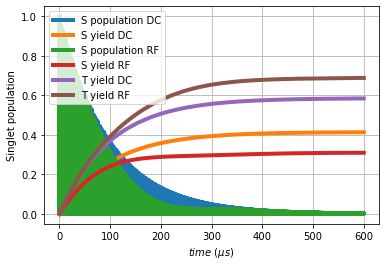

In [11]:
#Plot results
fig, ax = plt.subplots()
ax.plot(tlist * 1e6 * factor, singlet_population_DC, label='S population DC', linewidth=4.0)
ax.plot(tlist * 1e6 * factor, singlet_t_yield_DC, label='S yield DC', linewidth=4.0)
ax.plot(tlist * 1e6 * factor, singlet_population_RF, label='S population RF', linewidth=4.0)
ax.plot(tlist * 1e6 * factor, singlet_t_yield_RF, label='S yield RF', linewidth=4.0)
ax.plot(tlist * 1e6 * factor, triplet_t_yield_DC , label='T yield DC', linewidth=4.0)
ax.plot(tlist * 1e6 * factor, triplet_t_yield_RF , label='T yield RF', linewidth=4.0)

ax.set_xlabel(r'$time\ (\mu s)$')
ax.set_ylabel('Singlet population')
# ax.set_xlim(0,1)
ax.legend(loc=0)
ax.grid()
plt.show()

# Yields vs $\theta$
Here the yield is determined as the steady-state population of the shelving state. Basically, we need to wait long enough. We calculate for both orientation of the nuclear field and use their average.

In [12]:
thetas = np.linspace(0.0, pi, 21)
tlist = np.linspace(0.0, 6.0 / k, 20000)

## DC field

In [13]:
singlet_yield_up = []
singlet_yield_down = []

rho0 = S

print("DC evolution nuclear field")
for th in thetas:
    print(r"$\theta$ = ", th)
    result = mesolve(H_up(th), rho0, tlist, c_op_list, [ket2dm(SYield)])
    singlet_yield_up.append(result.expect[0][-1])
    result = mesolve(H_down(th), rho0, tlist, c_op_list, [ket2dm(SYield)])
    singlet_yield_down.append(result.expect[0][-1])

# convert to numpy arrays to find their average
singlet_yield_up, singlet_yield_down = np.array(singlet_yield_up), np.array(singlet_yield_down)

DC evolution nuclear field
$\theta$ =  0.0
$\theta$ =  0.15707963267948966
$\theta$ =  0.3141592653589793
$\theta$ =  0.47123889803846897
$\theta$ =  0.6283185307179586
$\theta$ =  0.7853981633974483
$\theta$ =  0.9424777960769379
$\theta$ =  1.0995574287564276
$\theta$ =  1.2566370614359172
$\theta$ =  1.413716694115407
$\theta$ =  1.5707963267948966
$\theta$ =  1.7278759594743862
$\theta$ =  1.8849555921538759
$\theta$ =  2.0420352248333655
$\theta$ =  2.199114857512855
$\theta$ =  2.356194490192345
$\theta$ =  2.5132741228718345
$\theta$ =  2.670353755551324
$\theta$ =  2.827433388230814
$\theta$ =  2.9845130209103035
$\theta$ =  3.141592653589793


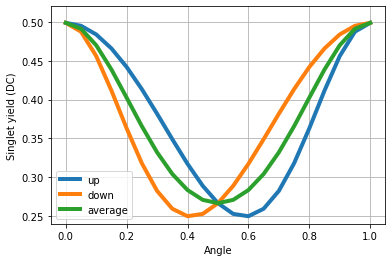

In [14]:
# Plot

fig, ax = plt.subplots()
ax.plot(thetas / pi, singlet_yield_up, label='up', linewidth=4.0)
ax.plot(thetas / pi, singlet_yield_down, label='down', linewidth=4.0)
ax.plot(thetas / pi, (singlet_yield_up + singlet_yield_down) / 2, label='average', linewidth=4.0)
ax.set_xlabel('Angle')
ax.set_ylabel('Singlet yield (DC)')
ax.set_ylim(0.24, 0.52)
ax.legend(loc=0)
ax.grid()
plt.show()

# DC + RF fields

In [15]:
rho0 = S
singlet_yield_up_RF = []
singlet_yield_down_RF = []

print("RF evolution nuclear field")

for th in thetas:
    print(r"$\theta = $", th)
    result = mesolve([H_up(th), H_RF(th, args)], rho0, tlist, c_op_list, [ket2dm(SYield)], args=args)
    singlet_yield_up_RF.append(result.expect[0][-1])
    result = mesolve([H_down(th), H_RF(th, args)], rho0, tlist, c_op_list, [ket2dm(SYield)], args=args)
    singlet_yield_down_RF.append(result.expect[0][-1])

singlet_yield_up_RF, singlet_yield_down_RF = np.array(singlet_yield_up_RF), np.array(singlet_yield_down_RF)

RF evolution nuclear field
$\theta = $ 0.0
$\theta = $ 0.15707963267948966
$\theta = $ 0.3141592653589793
$\theta = $ 0.47123889803846897
$\theta = $ 0.6283185307179586
$\theta = $ 0.7853981633974483
$\theta = $ 0.9424777960769379
$\theta = $ 1.0995574287564276
$\theta = $ 1.2566370614359172
$\theta = $ 1.413716694115407
$\theta = $ 1.5707963267948966
$\theta = $ 1.7278759594743862
$\theta = $ 1.8849555921538759
$\theta = $ 2.0420352248333655
$\theta = $ 2.199114857512855
$\theta = $ 2.356194490192345
$\theta = $ 2.5132741228718345
$\theta = $ 2.670353755551324
$\theta = $ 2.827433388230814
$\theta = $ 2.9845130209103035
$\theta = $ 3.141592653589793


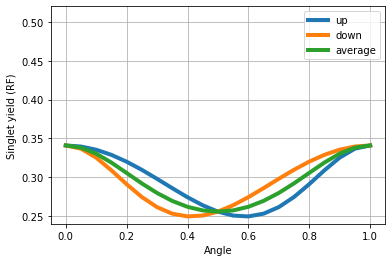

In [16]:
# Plot
fig, ax = plt.subplots()
ax.plot(thetas / pi, singlet_yield_up_RF, label='up', linewidth=4.0)
ax.plot(thetas / pi, singlet_yield_down_RF, label='down', linewidth=4.0)
ax.plot(thetas / pi, (singlet_yield_up_RF + singlet_yield_down_RF) / 2,
        label='average', linewidth=4.0)
ax.set_xlabel('Angle')
ax.set_ylabel('Singlet yield (RF)')
ax.set_ylim(0.24, 0.52)
ax.legend(loc=0)
ax.grid()
plt.show()

# RF resonance
Here we investigate the dependence of the singlet yield on the RF frequency when the DC field is parallel to the quantization axis. We compare the results obtained using the time-dependent Hamiltonian and the rotating-wave Hamiltonian, given by
$$
 \hat{H}_{rwa}/2\mu_B =  B_I|T_0\rangle\langle S|+ \dfrac{B_{rf}}{2}|T_+\rangle\langle T_0|+\left( B_I - \dfrac{\hbar}{2\mu_B}\delta_{rf} \right)|T_-\rangle\langle T_+|+\text{h.c.}
$$

In [17]:
# Time-dependent Hamiltonian

tlist3 = np.linspace(0.0, 4.0 / k, 20000)
theta3 = 0
rho0 = S

freq_list_RF = np.linspace(0.98, 1.02, 51)  # units of 2*gama*Bgeo

singlet_yield_vs_freq_RF = []
triplet_yield_vs_freq_RF = []

for freq in freq_list_RF:
    print(r'$\omega_{rf} = $', freq, 'r$\omega_g$')
    result = mesolve([H_up(theta3), H_RF(theta3, args)], rho0, tlist3, c_op_list, [ket2dm(SYield), ket2dm(TYield)],
    args={'A': Brf, 'freq': freq * 2 * gama * Bgeo})
    singlet_yield_vs_freq_RF.append(result.expect[0][-1])
    triplet_yield_vs_freq_RF.append(result.expect[1][-1])

singlet_yield_vs_freq_RF = np.array(singlet_yield_vs_freq_RF)
triplet_yield_vs_freq_RF = np.array(triplet_yield_vs_freq_RF)

$\omega_{rf} = $ 0.98 r$\omega_g$
$\omega_{rf} = $ 0.9808 r$\omega_g$
$\omega_{rf} = $ 0.9816 r$\omega_g$
$\omega_{rf} = $ 0.9823999999999999 r$\omega_g$
$\omega_{rf} = $ 0.9832 r$\omega_g$
$\omega_{rf} = $ 0.984 r$\omega_g$
$\omega_{rf} = $ 0.9848 r$\omega_g$
$\omega_{rf} = $ 0.9856 r$\omega_g$
$\omega_{rf} = $ 0.9863999999999999 r$\omega_g$
$\omega_{rf} = $ 0.9872 r$\omega_g$
$\omega_{rf} = $ 0.988 r$\omega_g$
$\omega_{rf} = $ 0.9888 r$\omega_g$
$\omega_{rf} = $ 0.9896 r$\omega_g$
$\omega_{rf} = $ 0.9904 r$\omega_g$
$\omega_{rf} = $ 0.9912 r$\omega_g$
$\omega_{rf} = $ 0.992 r$\omega_g$
$\omega_{rf} = $ 0.9928 r$\omega_g$
$\omega_{rf} = $ 0.9936 r$\omega_g$
$\omega_{rf} = $ 0.9944 r$\omega_g$
$\omega_{rf} = $ 0.9952 r$\omega_g$
$\omega_{rf} = $ 0.996 r$\omega_g$
$\omega_{rf} = $ 0.9968 r$\omega_g$
$\omega_{rf} = $ 0.9976 r$\omega_g$
$\omega_{rf} = $ 0.9984 r$\omega_g$
$\omega_{rf} = $ 0.9992 r$\omega_g$
$\omega_{rf} = $ 1.0 r$\omega_g$
$\omega_{rf} = $ 1.0008 r$\omega_g$
$\omega_{rf} 

In [18]:
# Rotating-wave approximation

tlist3 = np.linspace(0.0, 4.0 / k, 20000)

def H_RWA(rf_freq):
    """RF Hamiltonian in rotating-wave approximation
    when \theta = 0"""
    d = w - rf_freq
    Hz = gama * Sx * Brf / 2 + 0.5 * Sz * d  # one factor 0.5 is from RWA and the other one is due to electron's spin 1/2
    return Hz + Hhf

freq_list = np.linspace(0.98, 1.02, 201)  # units of 2*gama*Bgeo

singlet_yield_vs_freq_RWA = []
triplet_yield_vs_freq_RWA = []

for freq in freq_list:
    print(freq)
    result = mesolve(H_RWA(freq * w), rho0, tlist3, c_op_list, [ket2dm(SYield), ket2dm(TYield)])
    singlet_yield_vs_freq_RWA.append(result.expect[0][-1])
    triplet_yield_vs_freq_RWA.append(result.expect[1][-1])

singlet_yield_vs_freq_RWA = np.array(singlet_yield_vs_freq_RWA)
triplet_yield_vs_freq_RWA = np.array(triplet_yield_vs_freq_RWA)

0.98
0.9802
0.9803999999999999
0.9806
0.9808
0.981
0.9812
0.9813999999999999
0.9816
0.9818
0.982
0.9822
0.9823999999999999
0.9826
0.9828
0.983
0.9832
0.9833999999999999
0.9836
0.9838
0.984
0.9842
0.9843999999999999
0.9846
0.9848
0.985
0.9852
0.9853999999999999
0.9856
0.9858
0.986
0.9862
0.9863999999999999
0.9866
0.9868
0.987
0.9872
0.9873999999999999
0.9876
0.9878
0.988
0.9882
0.9884
0.9886
0.9888
0.989
0.9892
0.9894
0.9896
0.9898
0.99
0.9902
0.9904
0.9906
0.9908
0.991
0.9912
0.9914
0.9916
0.9918
0.992
0.9922
0.9924
0.9926
0.9928
0.993
0.9932
0.9934
0.9936
0.9938
0.994
0.9942
0.9944
0.9946
0.9948
0.995
0.9952
0.9954
0.9956
0.9958
0.996
0.9962
0.9964
0.9966
0.9968
0.997
0.9972
0.9974
0.9976
0.9978
0.998
0.9982
0.9984
0.9986
0.9988
0.999
0.9992
0.9994
0.9996
0.9998
1.0
1.0002
1.0004
1.0006
1.0008
1.001
1.0012
1.0014
1.0016
1.0018
1.002
1.0022
1.0024
1.0026
1.0028
1.0030000000000001
1.0032
1.0034
1.0036
1.0038
1.004
1.0042
1.0044
1.0046
1.0048
1.005
1.0052
1.0054
1.0056
1.0058
1.006
1.006

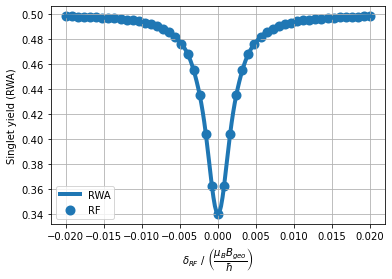

In [19]:
# Plot
total_yield_vs_freq_RWA = singlet_yield_vs_freq_RWA + triplet_yield_vs_freq_RWA
total_yield_vs_freq_RF = singlet_yield_vs_freq_RF + triplet_yield_vs_freq_RF
fig, ax = plt.subplots()
ax.plot(freq_list - 1, singlet_yield_vs_freq_RWA / total_yield_vs_freq_RWA, linewidth=4.0, label='RWA')
ax.scatter(freq_list_RF - 1, singlet_yield_vs_freq_RF / total_yield_vs_freq_RF, linewidth=4.0, label='RF')
ax.set_xlabel(r'$\delta_{RF}\ / \ \left(\dfrac{\mu_B B_{geo}}{\hbar}\right)$')
ax.set_ylabel('Singlet yield (RWA)')
ax.legend(loc=0)
ax.grid()

To be honest, I don't remember why we need to normalize the yield for the results to make sense.